# SDE Matching

## Imports ans Utilities

In [1]:
from typing import Any, Sequence, Callable
from abc import ABC, abstractmethod

import torch
from torch import nn, Tensor
from torch import distributions as D

import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
def solve_sde(
        sde: Callable[[Tensor, Tensor], tuple[Tensor, Tensor]],
        z: Tensor,
        ts: float,
        tf: float,
        n_steps: int
) -> Tensor:
    tt = torch.linspace(ts, tf, n_steps + 1)[:-1]
    dt = (tf - ts) / n_steps
    dt_2 = abs(dt) ** 0.5

    path = [z]
    for t in tt:
        f, g = sde(z, t)
        w = torch.randn_like(z)
        z = z + f * dt + g * w * dt_2

        path.append(z)

    return torch.stack(path)

In [3]:
def jvp(f: Callable[[Tensor], ...], x: Tensor, v: Tensor) -> tuple[Tensor, ...]:
    return torch.autograd.functional.jvp(
        f, x, v,
        create_graph=torch.is_grad_enabled()
    )

def t_dir(f: Callable[[Tensor], ...], t: Tensor) -> tuple[Tensor, ...]:
    return jvp(f, t, torch.ones_like(t))

def grad(f: Callable[[Tensor], ...], x: Tensor) -> tuple[Tensor, Tensor]:
    create_graph = torch.is_grad_enabled()

    with torch.enable_grad():
        x = x.clone()

        if not x.requires_grad:
            x.requires_grad = True

        y = f(x)

        (gradient, ) = torch.autograd.grad(y.sum(), x, create_graph=create_graph)

    return y, gradient

In [4]:
def visualise_data(xs: Tensor):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for xs_i in xs:
        ax.plot(xs_i[:, 0], xs_i[:, 1], xs_i[:, 2])

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)

In [5]:
class SDE(nn.Module, ABC):
    @abstractmethod
    def drift(self, z: Tensor, t: Tensor, *args: Any) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def vol(self, z: Tensor, t: Tensor, *args: Any) -> Tensor:
        raise NotImplementedError

    def forward(self, z: Tensor, t: Tensor, *args: Any) -> tuple[Tensor, Tensor]:
        drift = self.drift(z, t, *args)
        vol = self.vol(z, t, *args)
        return drift, vol

In [6]:
class StochasticLorenzSDE(SDE):
    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.15, .15, .15)):
        super().__init__()
        self.a = a
        self.b = b

    def drift(self, x: Tensor, t: Tensor, *args) -> Tensor:
        x1, x2, x3 = torch.split(x, [1, 1, 1], dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3

        return torch.cat([f1, f2, f3], dim=1)

    def vol(self, x: Tensor, t: Tensor, *args) -> Tensor:
        x1, x2, x3 = torch.split(x, [1, 1, 1], dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3

        return torch.cat([g1, g2, g3], dim=1)

In [7]:
def gen_data(
        batch_size: int,
        ts: float,
        tf: float,
        n_steps: int,
        noise_std: float,
        n_inner_steps: int=100
) -> tuple[Tensor, Tensor]:
    sde = StochasticLorenzSDE()

    z0 = torch.randn(batch_size, 3)
    zs = solve_sde(sde, z0, ts, tf, n_steps=n_steps * n_inner_steps)
    zs = zs[::n_inner_steps]
    zs = zs.permute(1, 0, 2)

    mean = torch.mean(zs, dim=(0, 1))
    std = torch.std(zs, dim=(0, 1))

    eps = torch.randn_like(zs)
    xs = (zs - mean) / std + noise_std * eps

    ts = torch.linspace(ts, tf, n_steps + 1)
    ts = ts[None, :, None].repeat(batch_size, 1, 1)

    return xs, ts

## Prior (Generative) Process

In [8]:
class PriorInitDistribution(nn.Module):
    def __init__(self, latent_size: int):
        super().__init__()

        self.m = nn.Parameter(torch.zeros(1, latent_size))
        self.log_s = nn.Parameter(torch.zeros(1, latent_size))

    def forward(self) -> D.Distribution:
        m = self.m
        s = torch.exp(self.log_s)
        return D.Independent(D.Normal(m, s), 1)

In [9]:
class PriorSDE(SDE):
    def __init__(self, latent_size: int, hidden_size: int):
        super().__init__()

        self.drift_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )

        self.vol_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )

    def drift(self, z: Tensor, t: Tensor, *args) -> Tensor:
        return self.drift_net(z)

    def vol(self, z: Tensor, t: Tensor, *args) -> Tensor:
        z = torch.split(z, 1, dim=1)
        g = [net_i(z_i) for net_i, z_i in zip(self.vol_nets, z)]
        return torch.cat(g, dim=1)

In [10]:
class PriorObservation(nn.Module):
    def __init__(self, latent_size: int, data_size: int, noise_std: float):
        super().__init__()

        self.net = nn.Linear(latent_size, data_size)
        self.noise_std = noise_std

    def get_coeffs(self, z: Tensor) -> tuple[Tensor, Tensor]:
        m = self.net(z)
        s = torch.ones_like(m) * self.noise_std
        return m, s

    def forward(self, z: Tensor) -> D.Distribution:
        m, s = self.get_coeffs(z)
        return D.Independent(D.Normal(m, s), 1)

## Posterior Process

In [11]:
class PosteriorEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x: Tensor) -> Tensor:
        out, h = self.gru(x)
        return torch.cat([h[0, :, None], out], dim=1)

In [12]:
class PosteriorAffine(nn.Module):
    def __init__(self, latent_size: int, hidden_size: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(hidden_size + 1, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * latent_size),
        )
        self.sm = nn.Softmax(dim=-1)

    def get_coeffs(self, ctx: Tensor, t: Tensor) -> tuple[Tensor, Tensor]:
        l = ctx.shape[1] - 1

        h, out = ctx[:, 0], ctx[:, 1:]
        ts = torch.linspace(0, 1, l)[None, :]
        c = self.sm(-(l * (ts - t)) ** 2)
        out = (out * c[:, :, None]).sum(dim=1)
        ctx_t = torch.cat([h + out, t], dim=1)

        m, log_s = self.net(ctx_t).chunk(chunks=2, dim=1)
        s = torch.exp(log_s)

        return m, s

    def forward(
            self,
            ctx: Tensor,
            t: Tensor,
            return_t_dir: bool = False
    ) -> tuple[Tensor, Tensor] | tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:
        if return_t_dir:
            def f(t_in: Tensor) -> Tensor:
                return self.get_coeffs(ctx, t_in)

            return t_dir(f, t)
        else:
            return self.get_coeffs(ctx, t)

## SDE Matching

In [13]:
class MatchingSDE(nn.Module):
    def __init__(
            self,
            p_init_distr: nn.Module,
            p_sde: SDE,
            p_observe: nn.Module,
            q_enc: nn.Module,
            q_affine: nn.Module
    ):
        super().__init__()

        self.p_init_distr = p_init_distr
        self.p_sde = p_sde
        self.p_observe = p_observe
        self.q_enc = q_enc
        self.q_affine = q_affine

    def loss_prior(self, ctx: Tensor) -> Tensor:
        bs = ctx.shape[0]

        t0 = torch.zeros(bs, 1)

        m0, s0 = self.q_affine(ctx, t0)
        q_z0 = D.Independent(D.Normal(m0, s0), 1)

        p_z0 = self.p_init_distr()

        loss_prior = D.kl_divergence(q_z0, p_z0)

        return loss_prior

    def loss_diff(self, ctx: Tensor, t: Tensor) -> Tensor:
        (m, s), (dm, ds) = self.q_affine(ctx, t, return_t_dir=True)

        eps = torch.randn_like(m)
        z = m + s * eps

        def g2_in(z_in):
            return self.p_sde.vol(z_in, t) ** 2

        g2, d_g2 = grad(g2_in, z)

        q_dz = dm + ds * eps
        q_score = - eps / s
        q_drift = q_dz + 0.5 * g2 * q_score + 0.5 * d_g2

        p_drift = self.p_sde.drift(z, t)

        loss_diff = 0.5 * (q_drift - p_drift) ** 2 / g2
        loss_diff = loss_diff.sum(dim=1)

        return loss_diff

    def loss_recon(self, ctx: Tensor, x: Tensor, t: Tensor) -> Tensor:
        m, s = self.q_affine(ctx, t)

        eps = torch.randn_like(m)
        z = m + s * eps

        p_x = self.p_observe(z)

        loss_recon = -p_x.log_prob(x)

        return loss_recon

    def forward(self, xs: Tensor, ts: Tensor) -> Tensor:
        bs = xs.shape[0]
        n = xs.shape[1]

        ctx = self.q_enc(xs)

        # prior loss
        loss_prior = self.loss_prior(ctx)

        # diffusion loss
        t = torch.rand(bs, 1) * (ts[:, -1] - ts[:, 0]) + ts[:, 0]

        loss_diff = self.loss_diff(ctx, t)

        # reconstruction loss
        rng = torch.arange(bs)
        u = torch.randint(n, [bs])
        t_u = ts[rng, u]
        x_u = xs[rng, u]

        loss_recon = self.loss_recon(ctx, x_u, t_u)

        # full loss
        loss = loss_prior + loss_diff + loss_recon

        return loss

## Training

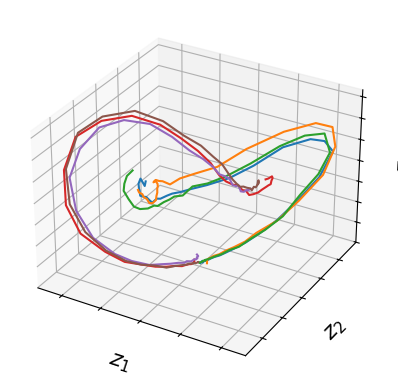

In [14]:
batch_size = 2 ** 10
ts = 0.
tf = 1.
n_steps = 40
noise_std = .01

xs, ts = gen_data(batch_size, ts, tf, n_steps, noise_std)

visualise_data(xs[:6])

In [15]:
def train(sde_matching: MatchingSDE, xs: Tensor, ts: Tensor):
    iter = 4000

    optim = torch.optim.Adam(sde_matching.parameters(), lr=0.001)

    pbar = trange(iter)
    for _ in pbar:
        loss = sde_matching(xs, ts)

        loss = loss.mean()

        pbar.set_description(f"{loss.item():.4f}")

        optim.zero_grad()
        loss.backward()
        optim.step()

In [16]:
data_size = 3
latent_size = 4
hidden_size = 100

p_init_distr = PriorInitDistribution(latent_size)
p_sde = PriorSDE(latent_size, hidden_size)
p_observe = PriorObservation(latent_size, data_size, noise_std)

q_enc = PosteriorEncoder(data_size, hidden_size)
q_affine = PosteriorAffine(latent_size, hidden_size)

sde_matching = MatchingSDE(p_init_distr, p_sde, p_observe, q_enc, q_affine)

train(sde_matching, xs, ts)

56.5047: 100%|██████████| 4000/4000 [10:41<00:00,  6.23it/s] 


## Visualization of the Learned Prior Process

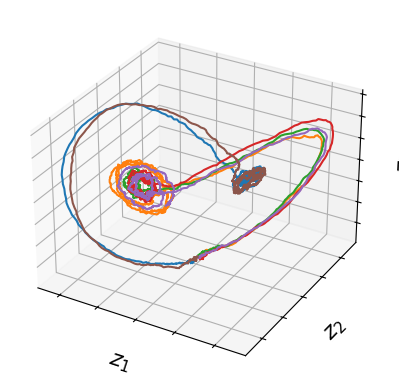

In [17]:
bs = 6

z0 = p_init_distr().rsample([bs])[:, 0]

zs = solve_sde(p_sde, z0, 0., 3, n_steps=1000)
zs = zs.permute(1, 0, 2)

zs = zs.reshape(-1, latent_size)
zs, _ = p_observe.get_coeffs(zs)
zs = zs.reshape(bs, -1, data_size)

visualise_data(zs.detach())